# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed
from statistics import mean 

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn


3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
from common_utils import split_dataset, preprocess_dataset
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df_train, y_train, df_test, y_test = split_dataset(df, ['filename'], 0.3, 42)
# Remove 'label' column from df_train and df_test to get X_train and X_test
X_train = df_train.drop(columns=["label"])
X_test = df_test.drop(columns=["label"])

def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}
    for batch_size in parameters:
        for train_index, val_index in kf.split(X_train, y_train):
            # -> train_index is a list of indices for the training set, val_index is a list of indices for the validation set
            y_train_dict[batch_size], y_val_dict[batch_size] = y_train[train_index], y_train[val_index]
            # Scale the X training set and X validation set
            standard_scaler = preprocessing.StandardScaler()
            X_train_, X_val_ = X_train.iloc[train_index], X_train.iloc[val_index]
            # Only fit the scaler to training data, not to validation nor test data
            X_train_scaled = standard_scaler.fit_transform(X_train_) # X_train_scaled is now np.ndarray
            X_val_scaled = standard_scaler.transform(X_val_) # X_val_scaled is now np.ndarray
            X_train_scaled_dict[batch_size] = X_train_scaled
            X_val_scaled_dict[batch_size] = X_val_scaled
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train, y_train)
# -> len(X_train_scaled_dict[batch_size]) = 33756 ie. 8439 * 4
# -> len(X_val_scaled_dict[batch_size]) = 8439

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [4]:
import time
from common_utils import EarlyStopper
no_epochs = 100

# YOUR CODE HERE
def train_val(model, loss_fn, optimizer, early_stopper, val_accuracies, val_losses, training_times, batch_size, training_dataloader, validation_dataloader):
	for epoch in range(no_epochs):
			# Training
			start_time = time.time()
			for i, (x, y) in enumerate(training_dataloader):
				# Compute prediction and Loss
				y_pred = model(x) # shape: [256, 1]
				y_pred = y_pred.squeeze(dim=1) # to get shape [256]
				loss = loss_fn(y_pred.float(), y.float())
				# Backpropagation
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
			training_time = time.time() - start_time
			training_times[batch_size] = training_time
			# Validation
			val_acc, val_loss = 0, 0
			no_input = len(validation_dataloader.dataset)
			no_batch = len(validation_dataloader)
			with torch.no_grad():
				for i, (x, y) in enumerate(validation_dataloader):
					# Prediction
					y_pred = model(x) # shape: [256, 1]
					y_pred = y_pred.squeeze(dim=1) # to get shape [256]
					# Compute loss and accuracy
					loss = loss_fn(y_pred.float(), y.float())
					val_loss += loss.item()
					# transform y_pred to give class 0 or class 1
					pred_label = [1 if i > 0.5 else 0 for i in y_pred]
					# compare pred_label with the ground truth y, add 1 to the accuracy variable if the prediction is correct
					val_acc += sum([1 if i == j else 0 for i, j in zip(pred_label, y)])
			val_loss /= no_batch
			val_acc /= no_input
			val_accuracies.append(val_acc)
			val_losses.append(val_loss)
			if early_stopper.early_stop(val_loss):
				print("Batch size: ", batch_size)
				print("Early stopping at epoch number: ", epoch+1, "validation accuracy: ", val_acc, '\n')
				break
	return val_accuracies, val_losses, training_times

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes=[128, 256, 512, 1024], mode='batch_size'):
	if mode != 'batch_size':
		print("Invalid mode")
		return
	mean_cross_validation_accuracies, training_times = {}, {}
	for batch_size in batch_sizes:
		model = MLP(no_hidden=128, no_features=77, no_labels=1)
		optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
		loss_fn = nn.BCELoss()
		early_stopper = EarlyStopper()
		# Load Data
		training_data = CustomDataset(X_train_scaled_dict[batch_size], y_train_dict[batch_size])
		training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
		validation_data = CustomDataset(X_val_scaled_dict[batch_size], y_val_dict[batch_size])
		validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
		# Train and Validate
		val_accuracies, val_losses = [], []
		val_accuracies, val_losses, training_times = train_val(model, loss_fn, optimizer, early_stopper, val_accuracies, val_losses, training_times, batch_size, training_dataloader, validation_dataloader)
		mean_cross_validation_accuracies[batch_size] = mean(val_accuracies)
	return mean_cross_validation_accuracies, training_times

batch_sizes = [128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


Batch size:  128
Early stopping at epoch number:  12 validation accuracy:  0.6662714878482513 

Batch size:  256
Early stopping at epoch number:  21 validation accuracy:  0.6917605216360403 

Batch size:  512
Early stopping at epoch number:  15 validation accuracy:  0.6342620035566093 

Batch size:  1024
Early stopping at epoch number:  10 validation accuracy:  0.6099585062240664 



5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

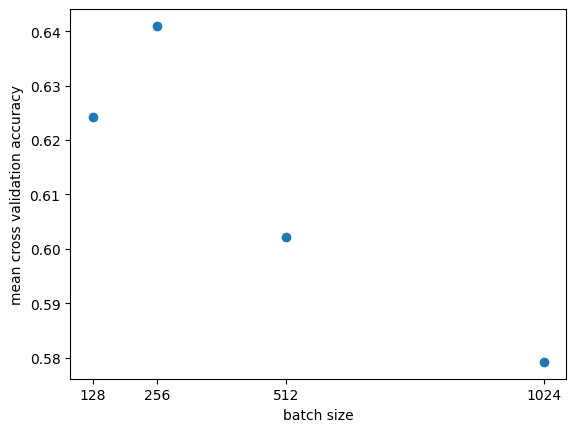

In [5]:
# YOUR CODE HERE
def acc_batchsize(cross_validation_accuracies):
	plt.figure(1)
	plt.ylabel("mean cross validation accuracy")
	plt.xticks(list(cross_validation_accuracies.keys()))
	plt.xlabel("batch size")
	plt.scatter(cross_validation_accuracies.keys(), cross_validation_accuracies.values())
	plt.show()

acc_batchsize(cross_validation_accuracies)

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [6]:
df = pd.DataFrame({'Batch Size': [128, 256, 512, 1024],
                   'Last Epoch Time': [cross_validation_times[128], cross_validation_times[256], cross_validation_times[512], cross_validation_times[1024]]
                  })

df

,Batch Size,Last Epoch Time
0,128,0.083396
1,256,0.068785
2,512,0.064132
3,1024,0.063908


In [8]:
# YOUR CODE HERE
optimal_batch_size = 256
reason = "It achieves the highest mean cross validation accuracy. While it does take a slightly longer time than 512 and 1024, it is more reasonable to prioritise accuracy because the training time for each epoch only takes 0.068785 seconds and from the above output, when early stopping is implemented only 21 epochs are needed. Hence, the total training time is less of a concern as compared to the accuracy of the model."